# Training and Modeling
- Scaling methods
- Defining Pipelines for Each Model, split the dataset, fit and score the model
- Model Hyperparameter Optimization
- Reports

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Scaling and pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

#Reports
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

import joblib
import pickle

In [2]:
data = pd.read_csv('../data/preprocessed_data/p_data')
data

,age,gender,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,family_history_diabetes,hypertension_history,cardiovascular_history,bmi,...,alcohol_consumption_per_week_1,alcohol_consumption_per_week_2,alcohol_consumption_per_week_3,alcohol_consumption_per_week_4,alcohol_consumption_per_week_5,alcohol_consumption_per_week_6,alcohol_consumption_per_week_7,alcohol_consumption_per_week_8,alcohol_consumption_per_week_9,alcohol_consumption_per_week_10
0,58.0,1.0,14.662878,5.7,7.9,7.9,0.0,0.0,0.0,30.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,48.0,0.0,11.958261,6.7,6.5,8.7,0.0,0.0,0.0,23.1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,60.0,1.0,7.549834,6.4,9.8,8.1,1.0,0.0,0.0,22.2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,74.0,0.0,7.000000,3.4,6.6,5.2,0.0,0.0,0.0,26.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,46.0,1.0,10.440307,7.2,7.4,5.0,0.0,0.0,0.0,21.2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,46.0,1.0,11.661904,8.3,6.4,4.5,0.0,0.0,0.0,29.8,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99996,41.0,0.0,8.717798,8.8,6.8,4.8,0.0,0.0,0.0,26.5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99997,57.0,0.0,11.000000,9.9,5.0,6.1,0.0,0.0,1.0,25.6,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
99998,47.0,0.0,7.211103,5.9,6.7,0.5,0.0,1.0,0.0,26.8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Checking for potential data leakage.
# Features with unusually high correlation to the target often indicate leakage.
df = data.copy()

corr = df.corr()['target'].abs().sort_values(ascending=False)

corr.head(20)

target                                1.000000
diabetes_stage_Type 2                 0.995349
diabetes_stage_Pre-Diabetes           0.837142
hba1c                                 0.681219
glucose_postprandial                  0.631280
glucose_fasting                       0.512568
diabetes_stage_No Diabetes            0.360676
diabetes_risk_score                   0.277524
family_history_diabetes               0.197926
age                                   0.137713
physical_activity_minutes_per_week    0.099161
bmi                                   0.097029
systolic_bp                           0.095417
waist_to_hip_ratio                    0.078898
ldl_cholesterol                       0.067458
cholesterol_total                     0.058087
insulin_level                         0.057738
triglycerides                         0.056185
hdl_cholesterol                       0.051084
diet_score                            0.044327
Name: target, dtype: float64

In [4]:
data = data.drop(columns=['diabetes_stage_Type 2', 'diabetes_stage_Pre-Diabetes', 'diabetes_stage_No Diabetes', 'diabetes_stage_Type 1'])

# Scaling Methods 

Below are the most commonly used scaling techniques in machine learning, along with their formulas and short descriptions.

 **1. StandardScaler**

$$X_{\text{scaled}} = \frac{X - \text{mean}}{\text{std}}$$

 **2. MinMaxScaler**
 
$$X_{\text{scaled}} = \frac{X - X_{\min}}{X_{\max} - X_{\min}}$$

 **3. RobustScaler**
 
$$X_{\text{scaled}} = \frac{X - median}{IQR}$$

$$IQR = Q3 - Q1$$

 **4. MaxAbsScaler**
 
$$X_{\text{scaled}} = \frac{X}{\max(|X|)}$$

We use `StandardScaler` because:

- It is the most appropriate method for **models sensitive to feature scale**, such as `Logistic Regression`, `SVM`, `KNN`.  
- It keeps the **distribution shape** similar but centers it at 0 with a variance of 1.  
- It prevents features with large numeric ranges from dominating the model training.  
- It works especially well after prior preprocessing steps like **log1p** and **outlier clipping**.

**In our case, StandardScaler is the correct choice because the model (Logistic Regression) requires features on a comparable scale, and we already handled outliers in preprocessing.**


### Defining Pipelines, Split the dataset, Train and score the models

---

##### Why we use ColumnTransformer with StandardScaler

We apply StandardScaler only to the numerical features (listed in NUMERICAL_FEATURES).

This ensures that all numeric variables are on the same scale, which helps many machine-learning models perform better.

##### Why we exclude categorical / encoded features

Categorical features that are already One-Hot encoded should not be scaled, because they contain only 0/1 values and scaling them would distort the meaning of the encoded categories.

By using remainder='passthrough', all non-numeric features pass through unchanged.

In [5]:
NUMERICAL_FEATURES = ['physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day',
                      'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total',
                      'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'glucose_fasting', 'glucose_postprandial', 'insulin_level', 
                      'hba1c', 'diabetes_risk_score']

preprocess = ColumnTransformer(
    [
        ('scale', StandardScaler(), NUMERICAL_FEATURES)
    ],
    remainder='passthrough',
    force_int_remainder_cols=False
)

##### Why we use a Pipeline for the models (Logistic Regression & SVC)

Both models are wrapped in a Pipeline together with the preprocessing step.
This ensures that the exact same scaling and transformation process is applied during training and during prediction.
The Pipeline guarantees a clean and reproducible workflow, where:

Preprocessing is always applied first
(preprocess → scaling only numerical features, keeping encoded features unchanged)

The model receives already-processed input data
avoiding data leakage and inconsistencies between train and test sets.

The preprocessing and model training are combined into a single object,
which simplifies cross-validation, hyperparameter tuning (GridSearchCV), and later model deployment.

Since both Logistic Regression and SVC require the data to be properly scaled for optimal performance, the shared comment applies to both Pipelines.

In [6]:
lr_model = Pipeline( steps = [
    ('preprocess', preprocess),
    ('lr_model', LogisticRegression(max_iter=1000, verbose=1))
])

In [7]:
# We include a LinearSVC model in the experiment because it trains significantly faster on large datasets.
# This allows us to compare performance across models without incurring excessive training time.
# In contrast, the standard SVC (especially with kernel-based methods) becomes extremely slow due to its
# quadratic computational complexity, making it practically unusable on datasets of this size (100k+ samples).
svc_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('svc_model', LinearSVC(max_iter=20000))
])

In [8]:
models = {
    "Logistic Regression": lr_model,
    "LinearSVC": svc_model,
}

##### Train–test split

We separate the dataset into features `X` and target `y`.
Then we split the data into training and testing sets using an `80/20 ratio`.

We use:

`stratify=y` to keep the same class distribution in both the train and test sets, which is important for classification tasks.

`random_state=42` to ensure reproducibility of the split.

`test_size=0.2` so that `20%` of the data is used for evaluation and `80%` for training.

This guarantees that the model is trained on a representative portion of the data and evaluated fairly on unseen samples.

In [9]:
X = data.drop(columns='target')
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)

##### Model Training and Evaluation Loop

We iterate through all models stored in the models dictionary.
For each model:

`model.fit(X_train, y_train)`
Trains the model on the training data.

`model.score(X_test, y_test)`
Evaluates the model on the test set using its default scoring metric (accuracy for classifiers).

Store the result in the `results dictionary`, mapping each model name to its accuracy score.

This loop allows us to `efficiently train and compare multiple machine-learning models using the same preprocessed data and evaluation procedure.`

In [10]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    results[name] = score

results

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished


{'Logistic Regression': 0.8619, 'LinearSVC': 0.8587}

In [11]:
model_result = pd.DataFrame(
    results.items(),
    columns=['Model', 'Score']
)
descending_ordered_model_result = model_result.sort_values(ascending=False, by='Score')
descending_ordered_model_result

,Model,Score
0,Logistic Regression,0.8619
1,LinearSVC,0.8587


### Model Hyperparameter Optimization

---

##### Hyperparameter Tuning for Logistic Regression (GridSearchCV)

We define a parameter grid `param_grid_lr` containing different values for the key Logistic Regression hyperparameters `C`, `penalty`, `max_iter`.
GridSearchCV performs an exhaustive search over all parameter combinations using:

`5-fold cross-validation (cv=5)`
Ensures robust evaluation across multiple data splits.

`scoring='roc_auc'`
Uses AUC as the optimization metric, which is more informative than accuracy for classification tasks.

`n_jobs=-1`
Utilizes all available CPU cores for faster computation.

Finally, `grid_lr.fit(X_train, y_train)` runs the hyperparameter search and trains the best model based on `cross-validated AUC`.

In [12]:
param_grid_lr = {
    'lr_model__penalty': ['l2'],
    'lr_model__C': [0.01, 0.1, 1, 10, 100],
}

grid_lr = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid_lr,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('scale',
                                                                         StandardScaler(),
                                                                         ['physical_activity_minutes_per_week',
                                                                          'diet_score',
                                                                          'sleep_hours_per_day',
                                                                          'screen_time_hours_per_day',
                                                                          'bmi',
                                                                          'waist_to_hip_ratio',
                                                                          'systolic_bp',
                                                                          'diastolic_bp',
                                                                          'heart_rate',
                                                                          'cholesterol_total',
                                                                          'hdl_cholesterol',
                                                                          'ldl_cholesterol',
                                                                          'triglycerides',
                                                                          'glucose_fasting',
                                                                          'glucose_postprandial',
                                                                          'insulin_level',
                                                                          'hba1c',
                                                                          'diabetes_risk_score'])])),
                                       ('lr_model',
                                        LogisticRegression(max_iter=1000,
                                                           verbose=1))]),
             n_jobs=-1,
             param_grid={'lr_model__C': [0.01, 0.1, 1, 10, 100],
                         'lr_model__penalty': ['l2']},
             scoring='roc_auc')

In [13]:
lr_model.score(X_test, y_test)

0.8619

##### Hyperparameter Tuning for SVC (GridSearchCV)

We define a parameter grid `param_grid_svc` to explore different values of the main `SVC` hyperparameters:

`C` - regularization strength

`kernel` - choice of kernel function `linear`, `rbf`, `poly`, `sigmoid`

GridSearchCV evaluates every parameter combination using:

`5-fold cross-validation (cv=5)` for robust performance estimation

`AUC score (scoring='roc_auc')` as the optimization metric

`n_jobs=-1` to speed up computation using all CPU cores

By calling `grid_svc.fit(X_train, y_train)`, we train and select the best-performing `SVC configuration` based on `cross-validated AUC`.

In [14]:
param_grid_svc = {
    'svc_model__C': [0.001, 0.01, 0.1, 1, 10],
    'svc_model__max_iter': [25000, 30000]
}

grid_svc = GridSearchCV(
    estimator=svc_model,
    param_grid=param_grid_svc,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_svc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('scale',
                                                                         StandardScaler(),
                                                                         ['physical_activity_minutes_per_week',
                                                                          'diet_score',
                                                                          'sleep_hours_per_day',
                                                                          'screen_time_hours_per_day',
                                                                          'bmi',
                                                                          'waist_to_hip_ratio',
                                                                          'systolic_bp',
                                                                          'diastolic_bp',
                                                                          'heart_rate',
                                                                          'cholesterol_total',
                                                                          'hdl_cholesterol',
                                                                          'ldl_cholesterol',
                                                                          'triglycerides',
                                                                          'glucose_fasting',
                                                                          'glucose_postprandial',
                                                                          'insulin_level',
                                                                          'hba1c',
                                                                          'diabetes_risk_score'])])),
                                       ('svc_model',
                                        LinearSVC(max_iter=20000))]),
             n_jobs=-1,
             param_grid={'svc_model__C': [0.001, 0.01, 0.1, 1, 10],
                         'svc_model__max_iter': [25000, 30000]},
             scoring='roc_auc')

In [15]:
svc_model.score(X_test, y_test)

0.8587

# Reports

---

In [16]:
y_pred_lr = lr_model.predict(X_test)
y_pred_svc = svc_model.predict(X_test)

##### Classification Report Interpretation

`Precision`
Measures how many of the samples predicted as positive are actually positive.
A value of 1.00 indicates there are no false positives.

`Recall`
Measures how many of the actual positive cases the model successfully detected.
A value of 1.00 means there are no false negatives.

`F1-score`
The harmonic mean of precision and recall.
A perfect score of 1.00 shows the model achieves an ideal balance between precision and recall.

`Support`
The number of true samples in each class:

Class 0 - 8,000

Class 1 - 12,000

`Accuracy`
The percentage of correctly predicted samples.
A value of 1.00 means the model classified all 20,000 samples correctly.

`Macro average`
The unweighted average across classes, treating each class equally.
A perfect macro average indicates balanced performance across both classes.

`Weighted average`
The average weighted by the number of samples in each class.
A perfect weighted score confirms excellent performance even with slight class imbalance.

In [17]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

         0.0       0.84      0.81      0.82      4000
         1.0       0.88      0.90      0.89      6000

    accuracy                           0.86     10000
   macro avg       0.86      0.85      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [18]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

         0.0       0.84      0.80      0.82      4000
         1.0       0.87      0.90      0.88      6000

    accuracy                           0.86     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.86      0.86      0.86     10000



##### What the Confusion Matrix Shows

The confusion matrix summarizes the model classification performance by comparing actual labels with predicted labels.

`True Positives (TP):`
Cases where the model correctly predicted class 1.

`True Negatives (TN):`
Cases where the model correctly predicted class 0.

`False Positives (FP):`
Cases where the model predicted 1, but the actual label was 0

`False Negatives (FN):`
Cases where the model predicted 0, but the actual label was 1

A confusion matrix helps visualize which types of errors the model makes, whether it favors one class over another, and how balanced the predictions are.

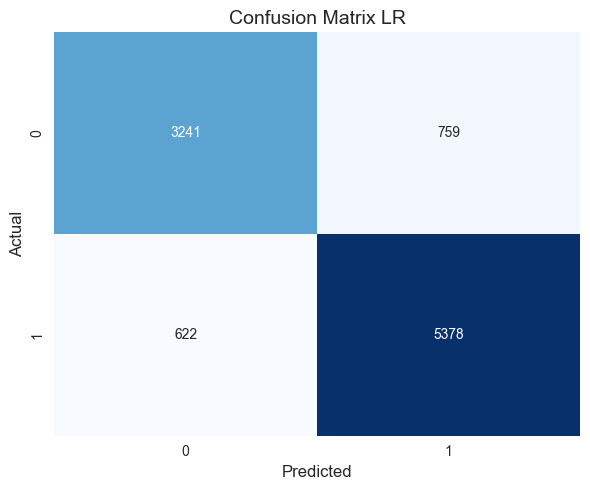

In [19]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 10})
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix LR", fontsize=14)
plt.tight_layout()
plt.show()

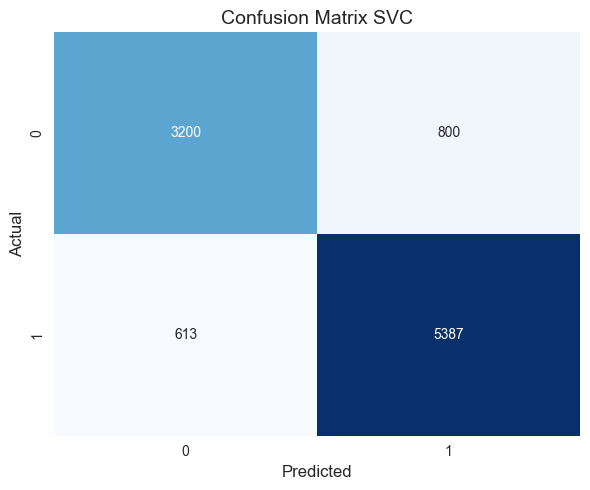

In [20]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_svc)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 10})
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix SVC", fontsize=14)
plt.tight_layout()
plt.show()

##### What the ROC Curve Shows

The `ROC curve` visualizes the model ability to distinguish between the two classes across all possible classification thresholds.

`True Positive Rate (TPR / Recall) on the Y-axis`

`False Positive Rate (FPR) on the X-axis`

Each point on the curve corresponds to a different decision threshold.

A `ROC curve` that bends toward the top-left corner indicates strong discriminative performance, meaning the model achieves high sensitivity while keeping false positives low.
The closer the curve is to the diagonal line, the closer the model is to random guessing.

The area under the curve `AUC` summarizes the overall ability of the model to separate the classes.

<Figure size 700x600 with 0 Axes>

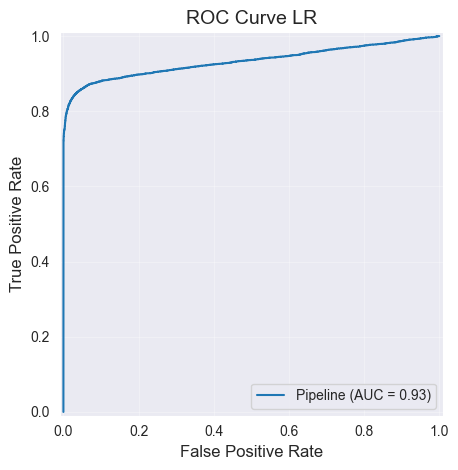

In [21]:
plt.figure(figsize=(7, 6))
RocCurveDisplay.from_estimator(lr_model, X_test, y_test)

plt.title("ROC Curve LR", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 700x600 with 0 Axes>

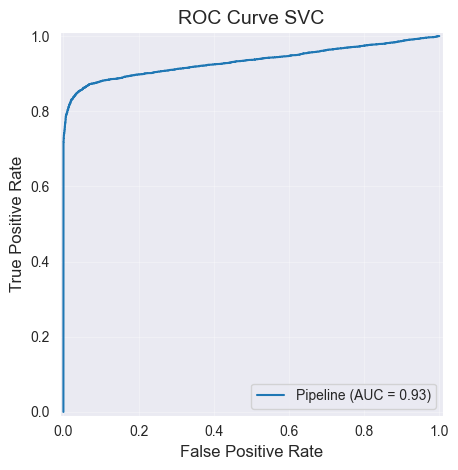

In [22]:
plt.figure(figsize=(7, 6))
RocCurveDisplay.from_estimator(svc_model, X_test, y_test)

plt.title("ROC Curve SVC", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
importance_logistic_regression = np.abs(lr_model.named_steps['lr_model'].coef_[0])

feature_importance_lr = (
    pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance_logistic_regression
    })
    .sort_values('Importance', ascending=False)
    .reset_index(drop=True)
)

feature_importance_lr = feature_importance_lr[:10]
feature_importance_lr

,Feature,Importance
0,ldl_cholesterol,2.766255
1,triglycerides,0.386482
2,insulin_level,0.293152
3,alcohol_consumption_per_week_9,0.255001
4,heart_rate,0.223806
5,alcohol_consumption_per_week_8,0.166913
6,alcohol_consumption_per_week_6,0.133083
7,alcohol_consumption_per_week_7,0.100764
8,income_level_Upper-Middle,0.088470
9,alcohol_consumption_per_week_4,0.076686


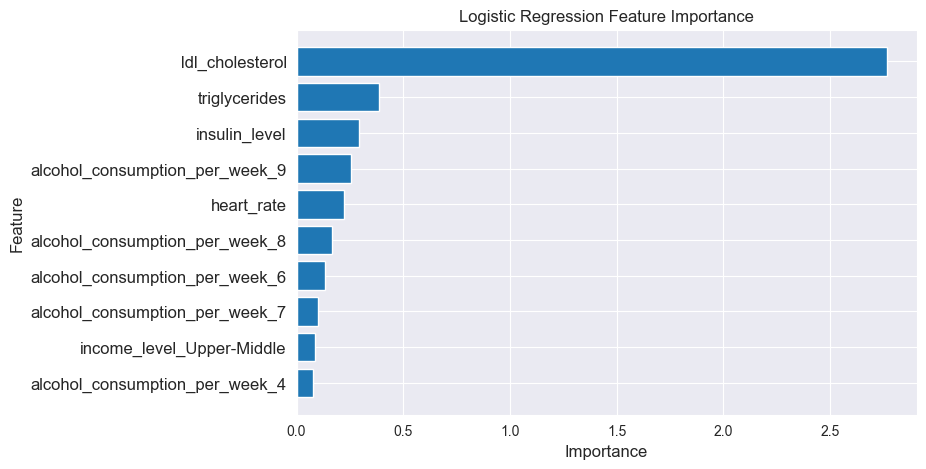

In [24]:
plt.figure(figsize=(8, 5))
plt.barh(feature_importance_lr['Feature'], feature_importance_lr['Importance'])

plt.gca().invert_yaxis()

plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Logistic Regression Feature Importance", fontsize=12)

plt.yticks(fontsize=12)

plt.show()

In [25]:
coef = svc_model.named_steps['svc_model'].coef_[0]

In [26]:
importance = np.abs(coef)

In [27]:
pre = svc_model.named_steps['preprocess']
feature_names = pre.get_feature_names_out() 

svc_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

svc_importance.reset_index(drop=True, inplace=True)
svc_importance = svc_importance[:10]
svc_importance

,Feature,Importance
0,scale__hba1c,0.893369
1,scale__diabetes_risk_score,0.136088
2,remainder__alcohol_consumption_per_week_9,0.124482
3,remainder__family_history_diabetes,0.109198
4,scale__glucose_fasting,0.072418
5,remainder__alcohol_consumption_per_week_8,0.060564
6,remainder__alcohol_consumption_per_week_6,0.042844
7,remainder__income_level_Upper-Middle,0.032335
8,remainder__income_level_Low,0.030551
9,remainder__income_level_Lower-Middle,0.029039


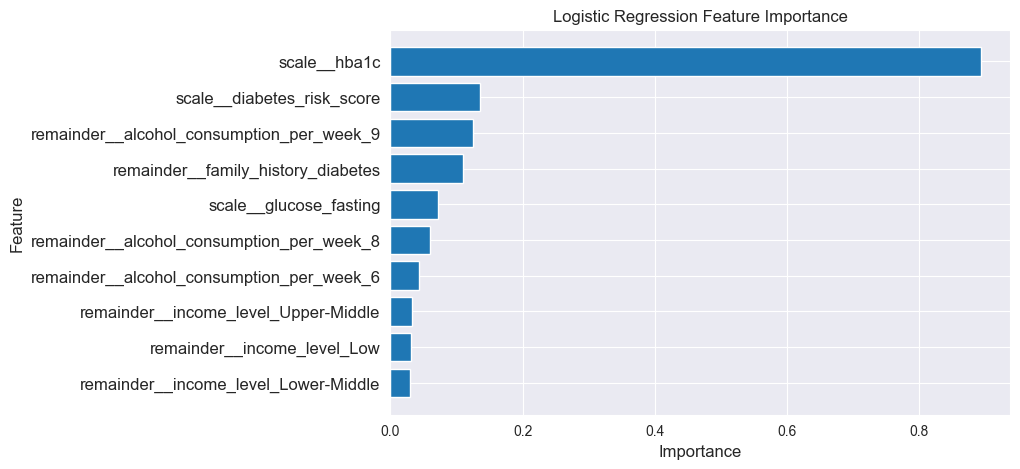

In [28]:
plt.figure(figsize=(8, 5))
plt.barh(svc_importance['Feature'], svc_importance['Importance'])

plt.gca().invert_yaxis()

plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Logistic Regression Feature Importance", fontsize=12)

plt.yticks(fontsize=12)

plt.show()

In [29]:
joblib.dump(lr_model, '../models/logistic_regression_model.pkl')

['../models/logistic_regression_model.pkl']

In [30]:
joblib.dump(svc_model, '../models/svc_model.pkl')

['../models/svc_model.pkl']

In [31]:
data.columns

Index(['age', 'gender', 'physical_activity_minutes_per_week', 'diet_score',
       'sleep_hours_per_day', 'screen_time_hours_per_day',
       'family_history_diabetes', 'hypertension_history',
       'cardiovascular_history', 'bmi', 'waist_to_hip_ratio', 'systolic_bp',
       'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol',
       'ldl_cholesterol', 'triglycerides', 'glucose_fasting',
       'glucose_postprandial', 'insulin_level', 'hba1c', 'diabetes_risk_score',
       'target', 'ethnicity_Black', 'ethnicity_Hispanic', 'ethnicity_Other',
       'ethnicity_White', 'education_level_Highschool',
       'education_level_No formal', 'education_level_Postgraduate',
       'income_level_Low', 'income_level_Lower-Middle', 'income_level_Middle',
       'income_level_Upper-Middle', 'employment_status_Retired',
       'employment_status_Student', 'employment_status_Unemployed',
       'smoking_status_Former', 'smoking_status_Never',
       'alcohol_consumption_per_week_1', '